In [128]:
import numpy as np
import mne
from collect_data import *

In [129]:
raw = get_bids_raw(meg_path, patient[0], session[0], '0')

Extracting SQD Parameters from /data01/data/MEG/sub-01/ses-0/meg/sub-01_ses-0_task-0_meg.con...
Creating Raw.info structure...
Setting channel info structure...
Creating Info structure...
Ready.
Reading events from /data01/data/MEG/sub-01/ses-0/meg/sub-01_ses-0_task-0_events.tsv.
Reading channel info from /data01/data/MEG/sub-01/ses-0/meg/sub-01_ses-0_task-0_channels.tsv.
The stimulus channel "STI 014" is present in the raw data, but not included in channels.tsv. Removing the channel.
Reading 0 ... 395999  =      0.000 ...   395.999 secs...


/home/matteoc/spect-to-meg/code/collect_data.py:47: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [130]:
print(raw)
print(raw.info)

<RawKIT | sub-01_ses-0_task-0_meg.con, 208 x 396000 (396.0 s), ~628.6 MB, data loaded>
<Info | 11 non-empty values
 bads: []
 ch_names: MEG 001, MEG 002, MEG 003, MEG 004, MEG 005, MEG 006, MEG 007, ...
 chs: 208 Magnetometers
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 experimenter: mne_anonymize
 highpass: 0.5 Hz
 kit_system_id: 442 (New York University Abu Dhabi, 2014-)
 lowpass: 30.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 nchan: 208
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 8 items (dict)
>


Effective window size : 2.048 (s)


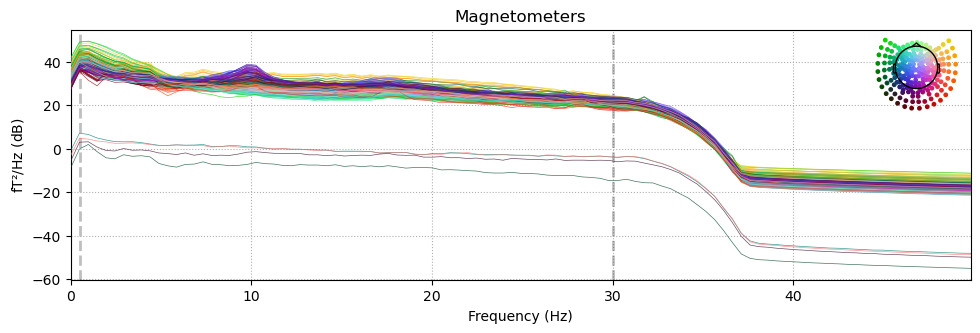

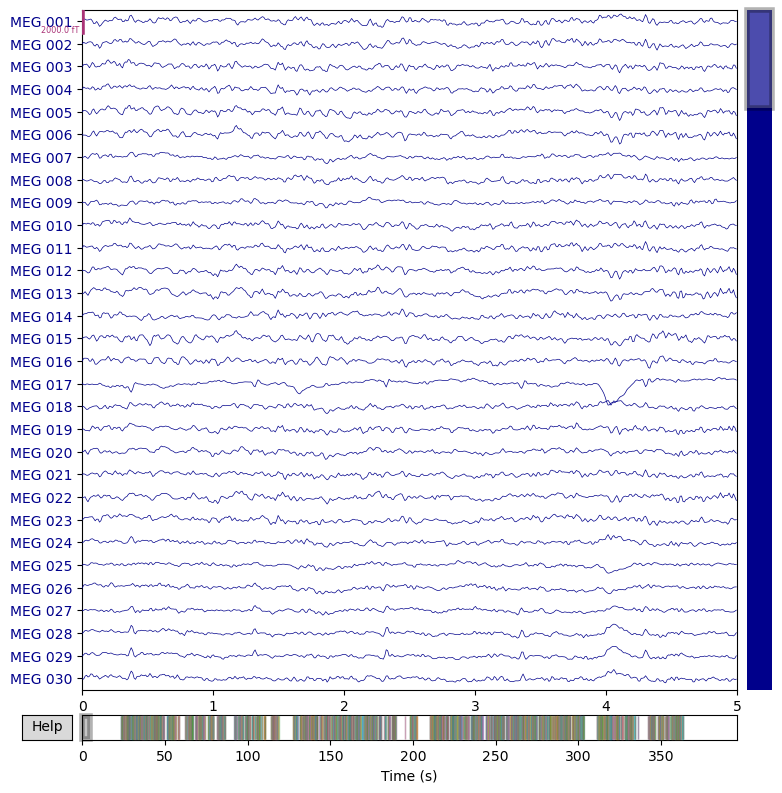

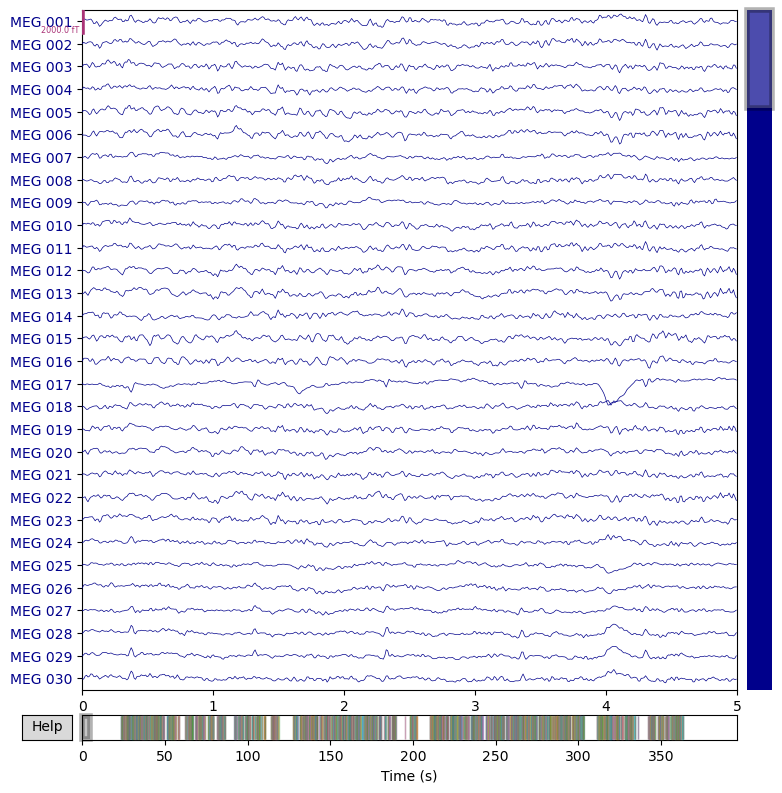

In [131]:
raw.compute_psd(fmax=50).plot(picks="data", exclude="bads")
raw.plot(duration=5, n_channels=30)

Fitting ICA to data using 208 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 12.5s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
198 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
198 matching events found
No baseline correction applied
0 projection items activated


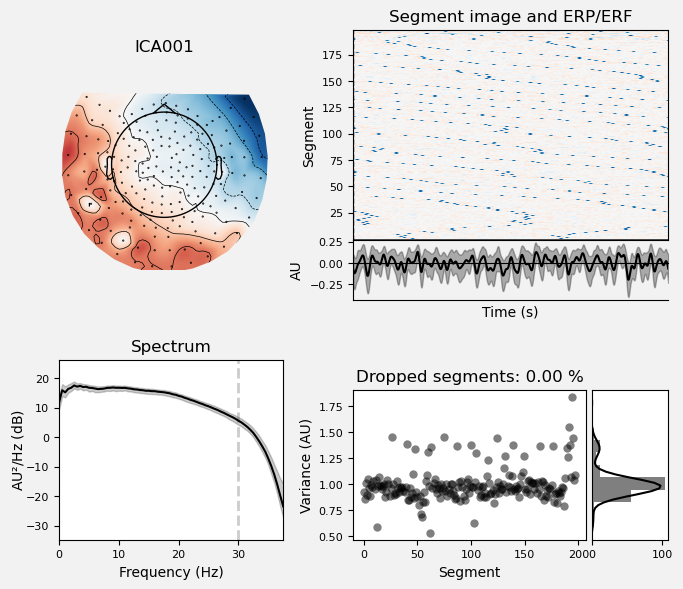

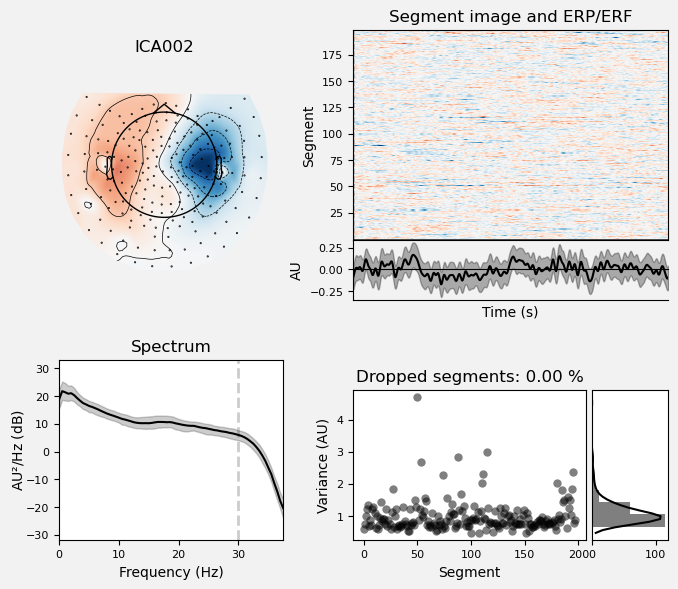

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [132]:
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

In [133]:
meta = list()
for annot in raw.annotations:
    d = eval(annot.pop("description"))
    for k, v in annot.items():
        assert k not in d.keys()
        d[k] = v
    meta.append(d)
meta = pd.DataFrame(meta)
meta = meta.sample(n=10, random_state=43)

events = np.c_[
    meta.onset * raw.info["sfreq"], np.ones((len(meta), 2))
].astype(int)



In [134]:
epochs = mne.Epochs(
    raw,
    events,
    tmin=-0.200,
    tmax=3,  
    decim=1, 
    baseline=(-0.2, 0.0),
    metadata=meta,
    preload=True,
    event_repeated="drop",
)

Adding metadata with 17 columns
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 10 events and 3201 original time points ...
0 bad epochs dropped


/tmp/ipykernel_219075/1071337354.py:1: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(


Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated


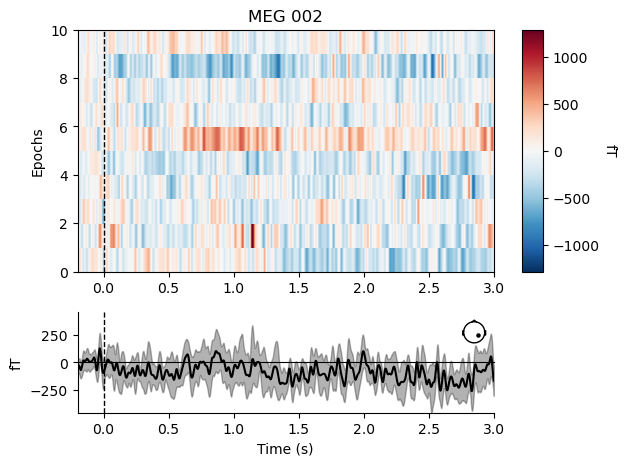

[<Figure size 640x480 with 4 Axes>]

In [135]:
epochs.plot_image(picks=["MEG 002"])

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    8.5s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


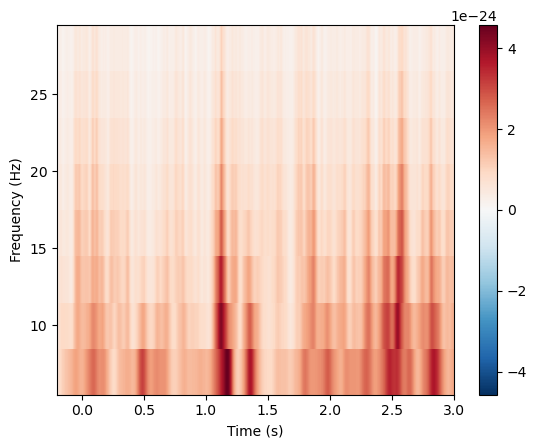

[<Figure size 640x480 with 2 Axes>]

In [136]:
frequencies = np.arange(7, 30, 3)
power = mne.time_frequency.tfr_morlet(
    epochs, n_cycles=2, return_itc=False, freqs=frequencies, decim=1)
power.plot(["MEG 002"])

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


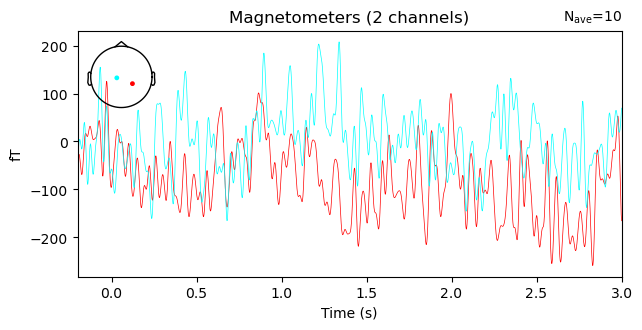

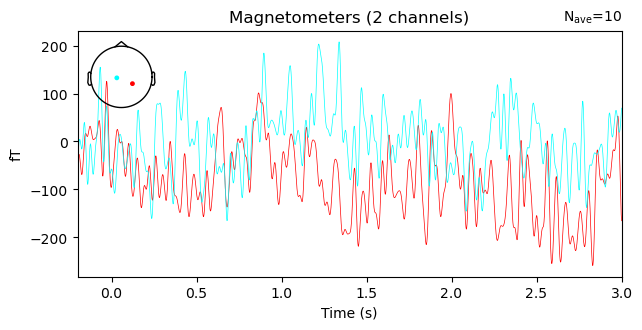

In [143]:
evoked = epochs.average()
mne.viz.plot_evoked(evoked, picks=['MEG 002','MEG 022'], spatial_colors=True)

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


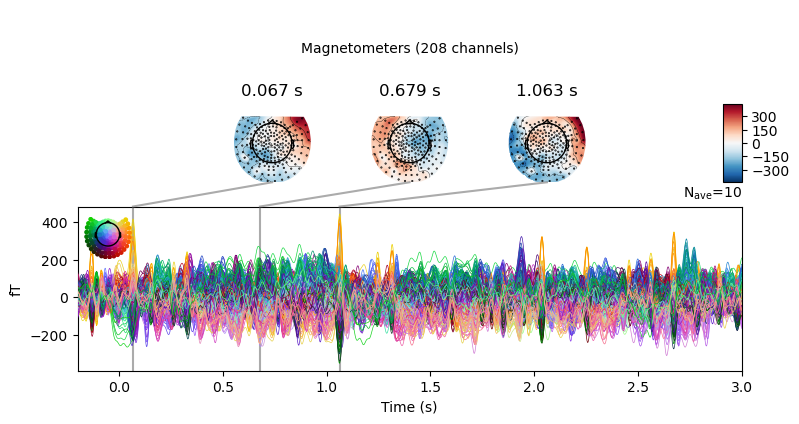

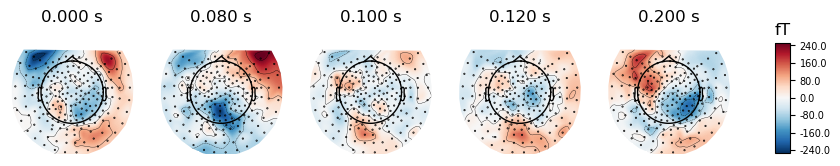

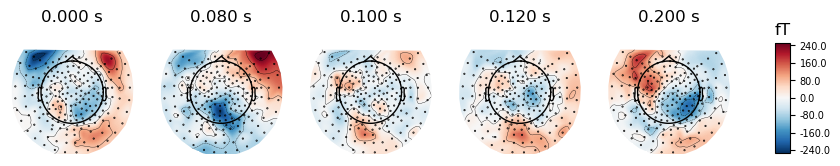

In [138]:
evoked.plot_joint(picks="meg")
evoked.plot_topomap(times=[0.0, 0.08, 0.1, 0.12, 0.2], ch_type="mag")